<a href="https://colab.research.google.com/github/meltyyyyy/kaggle-amex/blob/main/Notebooks/CatBoost/Aggregation001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
class Config:
    name = "CatBoost/Agg003"

    n_splits = 5
    seed = 2022
    target = "target"

    # Colab Env
    upload_from_colab = True
    api_path = "/content/drive/MyDrive/workspace/kaggle.json"
    drive_path = "/content/drive/MyDrive/workspace/kaggle-amex"
    
    # Kaggle Env
    kaggle_dataset_path = None
    
    # Reka Env
    dir_path = '/home/abe/kaggle/kaggle-amex'

In [2]:
import os
import json
import warnings
import shutil
import logging
import random
import datetime
import sys
import gc
import multiprocessing
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cupy, cudf
warnings.filterwarnings('ignore')

## Environment Settings

In [3]:
INPUT = os.path.join(Config.dir_path, 'input')
OUTPUT = os.path.join(Config.dir_path, 'output')
SUBMISSION = os.path.join(Config.dir_path, 'submissions')
OUTPUT_EXP = os.path.join(OUTPUT, Config.name)
EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

# make dirs
for d in [INPUT, SUBMISSION, EXP_MODEL, EXP_FIG, EXP_PREDS]:
    os.makedirs(d, exist_ok=True)

In [4]:
train = cudf.read_parquet(os.path.join(INPUT, 'train.parquet'))
# test = cudf.read_parquet(os.path.join(INPUT, 'test.parquet'))
target = cudf.read_csv(os.path.join(INPUT, 'train_labels.csv'))
train['S_2'] = cudf.to_datetime(train['S_2'])
# test['S_2'] = cudf.to_datetime(test['S_2'])
train = train.fillna(-127)
# test = test.fillna(-127)

In [5]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: datetime64[ns](1), float32(93), int16(9), int8(86), object(1)
memory usage: 2.8+ GB


In [6]:
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,-127.0,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,-127.0,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,-127.0,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,-127.0,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,-127.0,0,0.008126,0


## Evaluation Metric

In [7]:
# https://www.kaggle.com/code/inversion/amex-competition-metric-python

def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

class AmexMetric(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        # the larger metric value the better
        return True

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        preds = np.array(approxes[0])
        target = np.array(target)
        return amex_metric(pd.DataFrame({'target': target}), pd.Series(preds, name='prediction')), 0

## Feature Engineering

In [8]:
def add_agg_features(df):
    # FEATURE ENGINEERING FROM 
    # https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    num_features = [col for col in all_cols if col not in cat_features]

    num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    num_agg.columns = ['_'.join(x) for x in num_agg.columns]

    cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    cat_agg.columns = ['_'.join(x) for x in cat_agg.columns]

    df = cudf.concat([num_agg, cat_agg], axis=1)
    del num_agg, cat_agg
    return df

train = add_agg_features(train)
# test = add_agg_features(test)

## Create Target

In [9]:
# ADD TARGETS
target = target.set_index('customer_ID')
train = train.merge(target, left_index=True, right_index=True, how='left')
train.target = train.target.astype('int8')
del target

In [10]:
# NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
train = train.sort_index().reset_index()
# FEATURES
features = train.columns[1:-1]

## Select features to use

In [11]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

def fit_catboost(X, y, cat_features=None, params=None):
  models = []
  scores = []

  skf = StratifiedKFold(n_splits=Config.n_splits, shuffle=True, random_state=Config.seed)
  
  for fold, (train_indices, valid_indices) in enumerate(tqdm(skf.split(X, y))):
    print("-"*50+f' fold{fold} '+'-'*50)
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_valid, y_valid = X.iloc[valid_indices], y.iloc[valid_indices]

    model = CatBoostClassifier(**params,
                              #  eval_metric=AmexMetric(),
                               task_type='GPU',
                               iterations=100000,
                               random_seed=Config.seed,
                               verbose=0)
    
    model.fit(X_train, y_train,
              cat_features=cat_features,
              eval_set=[(X_valid, y_valid)],
              early_stopping_rounds=10,
              verbose_eval=50)
    
    # ------------------- prediction -------------------
    pred = model.predict_proba(X_valid)[:, 1]
    score = amex_metric(pd.DataFrame({'target': y_valid.values}), pd.Series(pred, name='prediction'))

    # ------------------- save -------------------
    file = f'{EXP_MODEL}/catboost_fold{fold}.pkl'
    model.save_model(file, format='cbm')
    scores.append(score)
    models.append(model)
    print(f'fold{fold} amex meric: {score}')
    print()

  print(f"OOF Score: {np.mean(scores):.5f}")
  return models

def inference_catboost(models, X):
    pred = np.array([model.predict_proba(X) for model in models])
    pred = np.mean(pred, axis=0)[:, 1]
    return pred

## Training

In [12]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

def fit_catboost(X, y, cat_features=None, params=None):
  models = []
  scores = []

  skf = StratifiedKFold(n_splits=Config.n_splits, shuffle=True, random_state=Config.seed)
  
  for fold, (train_indices, valid_indices) in enumerate(skf.split(X, y)):
    print("-"*50+f' fold{fold} '+'-'*50)
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_valid, y_valid = X.iloc[valid_indices], y.iloc[valid_indices]

    model = CatBoostClassifier(**params,
                              #  eval_metric=AmexMetric(),
                               task_type='GPU',
                               iterations=10000,
                               random_seed=Config.seed,
                               verbose=0)
    
    model.fit(X_train, y_train,
              cat_features=cat_features,
              eval_set=[(X_valid, y_valid)],
              early_stopping_rounds=10,
              verbose_eval=0)
    
    # ------------------- prediction -------------------
    pred = model.predict_proba(X_valid)[:, 1]
    score = amex_metric(pd.DataFrame({'target': y_valid.values}), pd.Series(pred, name='prediction'))

    # ------------------- save -------------------
    file = f'{EXP_MODEL}/catboost_fold{fold}.pkl'
    model.save_model(file, format='cbm')
    scores.append(score)
    models.append(model)
    print(f'fold{fold} amex meric: {score}')
    print()

  print(f"OOF Score: {np.mean(scores):.5f}")
  return models

def inference_catboost(models, X):
    pred = np.array([model.predict_proba(X) for model in models])
    pred = np.mean(pred, axis=0)[:, 1]
    return pred

In [13]:
cat_params = {}
cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
cat_features = [f'{cat_col}_last' for cat_col in cat_features]

train = train.to_pandas()

models = fit_catboost(train[features], train[Config.target], cat_features=cat_features, params=cat_params)
# models = [joblib.load(f'{EXP_MODEL}/catboost_fold{i}.pkl') for i in range(Config.n_splits)]
del train

-------------------------------------------------- fold0 --------------------------------------------------
fold0 amex meric: 0.7827810972812832

-------------------------------------------------- fold1 --------------------------------------------------
fold1 amex meric: 0.7819183412517157

-------------------------------------------------- fold2 --------------------------------------------------
fold2 amex meric: 0.7894258687096146

-------------------------------------------------- fold3 --------------------------------------------------
fold3 amex meric: 0.7863728091360714

-------------------------------------------------- fold4 --------------------------------------------------
fold4 amex meric: 0.7854512314978481

OOF Score: 0.78519


## Plot importances

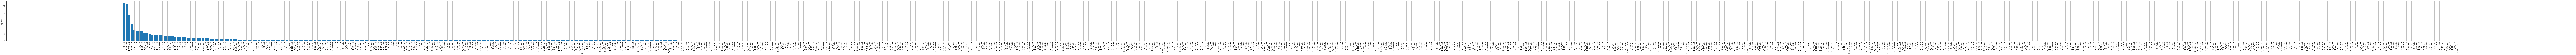

In [14]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

## Inference

In [16]:
test = cudf.read_parquet(os.path.join(INPUT, 'test.parquet'))
test['S_2'] = cudf.to_datetime(test['S_2'])
test = test.fillna(-127)

test = add_agg_features(test)
test = test.to_pandas()
pred = inference_catboost(models, test[features])

## Submission

In [ ]:
sub = pd.DataFrame({'customer_ID': test.index,
                    'prediction': pred})
sub.to_csv(f'{SUBMISSION}/submission.csv', index=False)

In [ ]:
! kaggle competitions submit -c amex-default-prediction -f /content/drive/MyDrive/workspace/kaggle-amex/Submission/submission.csv -m "CatBoost Baseline"